In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

## Import dependencies

In [47]:
import altair as alt
from altair import datum

import pandas as pd
import seaborn as sns
from IPython.display import display

from configs import config
from utils.data_viz_utils import create_average_metrics_df, visualize_fairness_metrics_for_prediction_metric
from utils.custom_classes.metrics_composer import MetricsComposer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [48]:
STATE = config.DATASET_CONFIG['state']
YEAR = config.DATASET_CONFIG['year']
DATASET_NAME = f"Folktables_{STATE}_{YEAR}"

MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG]

In [49]:
models_average_results_dct = create_average_metrics_df(DATASET_NAME, MODELS_NAMES,
                                                       results_path=os.path.join('..', '..', 'results', 'hypothesis_space',
                                                                                 'folktables_GA_2018_metrics'))

File with average metrics for LogisticRegression is created
File with average metrics for DecisionTreeClassifier is created
File with average metrics for RandomForestClassifier is created
File with average metrics for XGBClassifier is created
File with average metrics for KNeighborsClassifier is created
File with average metrics for MLPClassifier_1L_100 is created
File with average metrics for MLPClassifier_3L_100_50_100 is created


## Visualize average metrics

In [50]:
PROTECTED_GROUPS = ['SEX','RAC1P', 'SEX_RAC1P']

metrics_composer = MetricsComposer(PROTECTED_GROUPS, models_average_results_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,SEX,RAC1P,SEX_RAC1P
Equalized_Odds_TPR,-0.026957,0.029055,0.003553
Equalized_Odds_FPR,0.091946,-0.001902,0.088360
Disparate_Impact,1.140465,1.065675,1.174613
Statistical_Parity_Difference,0.148011,0.072391,0.177042
Accuracy_Parity,-0.066899,0.010552,-0.050567
Label_Stability_Ratio,0.969949,0.992203,0.958893
IQR_Parity,0.003000,0.003400,0.007200
Std_Parity,0.000700,0.004200,0.005700
Std_Ratio,1.012915,1.078947,1.106145
Jitter_Parity,0.017100,0.004700,0.023800


### Overall metrics visualizations

In [51]:
def visualize_overall_metrics(models_average_results_dct, metrics_names, reversed_metrics_names=[], x_label="Prediction Metrics"):
    metrics_names = set(metrics_names + reversed_metrics_names)

    overall_metrics_df = pd.DataFrame()
    for model_name in models_average_results_dct.keys():
        model_average_results_df = models_average_results_dct[model_name].reset_index().copy(deep=True)
        model_average_results_df = model_average_results_df.loc[model_average_results_df['index'].isin(metrics_names)]
        overall_model_metrics_df = pd.DataFrame()
        overall_model_metrics_df['overall'] = model_average_results_df['overall']
        overall_model_metrics_df['metric'] = model_average_results_df['index']
        overall_model_metrics_df['model_name'] = model_name
        overall_metrics_df = pd.concat([overall_metrics_df, overall_model_metrics_df])

    overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall'] = \
        1 - overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall']

    # Draw a nested barplot
    height = 9 if len(metrics_names) >= 7 else 6
    g = sns.catplot(
        data=overall_metrics_df, kind="bar",
        x="overall", y="metric", hue="model_name",
        errorbar="sd", palette="bright",
        alpha=.8, height=height
    )
    g.despine(left=True)
    g.set_axis_labels("", x_label)
    g.legend.set_title("")


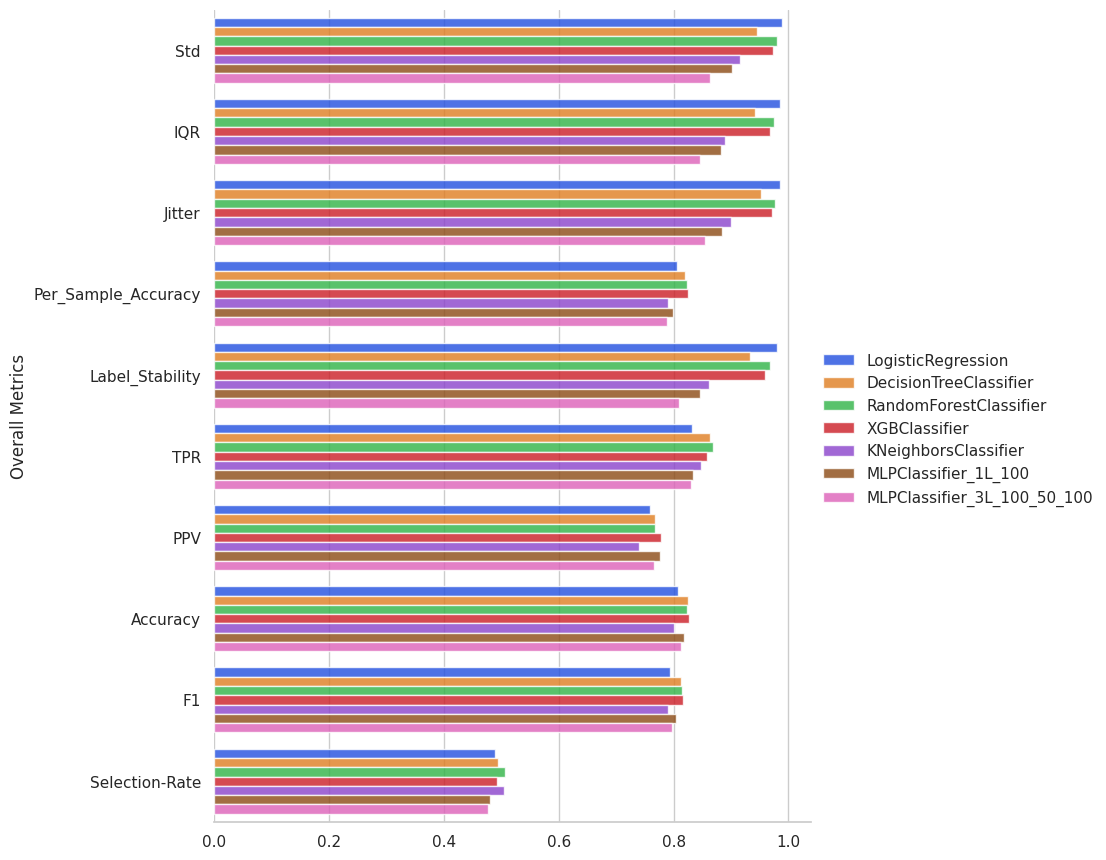

In [53]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                                         'Per_Sample_Accuracy', 'Label_Stability'],
                          reversed_metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Overall Metrics")

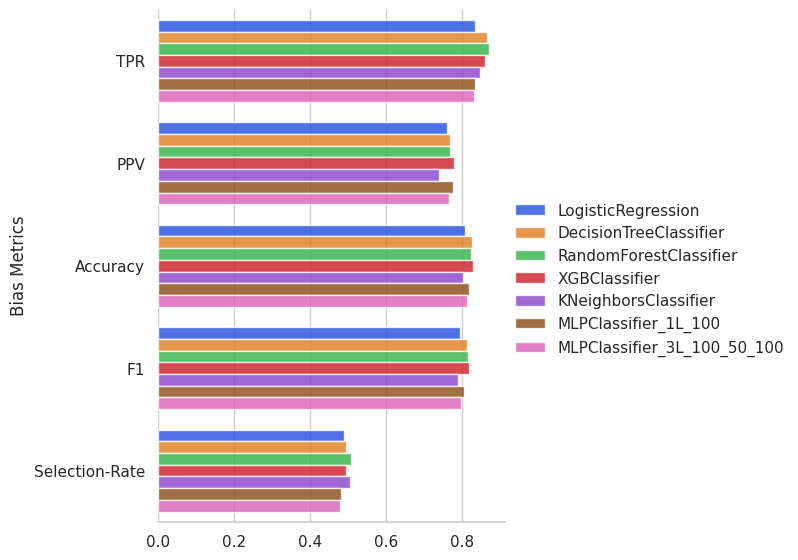

In [54]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
                          x_label="Bias Metrics")

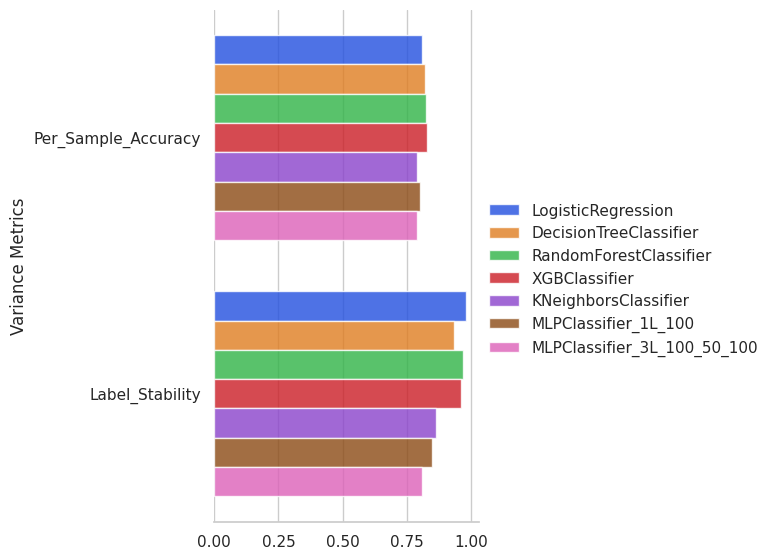

In [55]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
                          x_label="Variance Metrics")

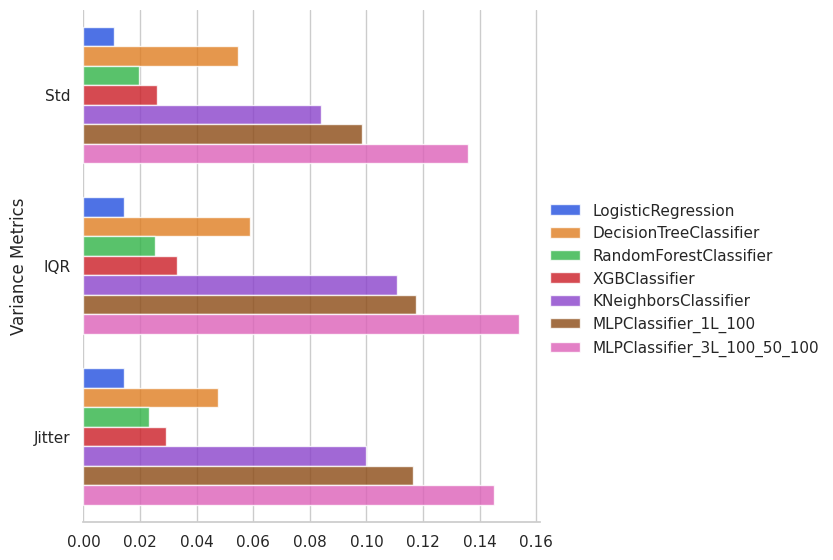

In [56]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Variance Metrics")

In [57]:
models_average_results_df = pd.DataFrame()

for model_name in models_average_results_dct.keys():
    model_results_df = models_average_results_dct[model_name].reset_index()
    model_results_df['Model_Name'] = model_name
    model_results_df = model_results_df.rename(columns={"index": "Metric"})
    
    models_average_results_df = pd.concat([models_average_results_df, model_results_df])

models_average_results_df.head(30)

,Metric,overall,SEX_RAC1P_priv,SEX_RAC1P_dis,SEX_priv,SEX_dis,RAC1P_priv,RAC1P_dis,Model_Name
0,General_Ensemble_Accuracy,0.806900,0.834800,0.784300,0.834900,0.779800,0.806100,0.808300,LogisticRegression
1,Mean,0.552900,0.496200,0.593100,0.519600,0.585000,0.538300,0.580600,LogisticRegression
2,Std,0.010800,0.010300,0.012300,0.010700,0.010900,0.010200,0.011900,LogisticRegression
3,IQR,0.014400,0.013800,0.016400,0.014300,0.014500,0.013600,0.015900,LogisticRegression
4,Entropy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LogisticRegression
5,Jitter,0.014200,0.013000,0.014400,0.013600,0.014700,0.014000,0.014600,LogisticRegression
6,Per_Sample_Accuracy,0.806100,0.834000,0.783600,0.834200,0.779000,0.805200,0.807700,LogisticRegression
7,Label_Stability,0.980100,0.981800,0.980000,0.980900,0.979300,0.980300,0.979600,LogisticRegression
8,TPR,0.831983,0.886848,0.778497,0.883288,0.773995,0.835698,0.824347,LogisticRegression
9,TNR,0.786559,0.780390,0.788480,0.789648,0.783940,0.780992,0.796504,LogisticRegression


In [58]:
df_for_models_bias_metrics_chart = models_average_results_df.melt(id_vars=["Metric", "Model_Name", "overall"],
                                                                  var_name="Subgroup",
                                                                  value_name="Value")
df_for_models_bias_metrics_chart[df_for_models_bias_metrics_chart["Model_Name"] == "LogisticRegression"]

,Metric,Model_Name,overall,Subgroup,Value
0,General_Ensemble_Accuracy,LogisticRegression,0.806900,SEX_RAC1P_priv,0.834800
1,Mean,LogisticRegression,0.552900,SEX_RAC1P_priv,0.496200
2,Std,LogisticRegression,0.010800,SEX_RAC1P_priv,0.010300
3,IQR,LogisticRegression,0.014400,SEX_RAC1P_priv,0.013800
4,Entropy,LogisticRegression,0.000000,SEX_RAC1P_priv,0.000000
...,...,...,...,...,...
607,FPR,LogisticRegression,0.213441,RAC1P_dis,0.203496
608,Accuracy,LogisticRegression,0.806851,RAC1P_dis,0.808312
609,F1,LogisticRegression,0.793753,RAC1P_dis,0.784826
610,Selection-Rate,LogisticRegression,0.489763,RAC1P_dis,0.466782


In [59]:
models_composed_metrics_df = pd.DataFrame()
for model_name in models_average_results_dct.keys():
    metrics_composer = MetricsComposer(PROTECTED_GROUPS, models_average_results_dct[model_name])
    model_composed_metrics_df = metrics_composer.compose_metrics().reset_index()
    model_composed_metrics_df['Model_Name'] = model_name
    model_composed_metrics_df = model_composed_metrics_df.rename(columns={"index": "Metric"})
    
    models_composed_metrics_df = pd.concat([models_composed_metrics_df, model_composed_metrics_df])

models_composed_metrics_df.head(20)

,Metric,SEX,RAC1P,SEX_RAC1P,Model_Name
0,Equalized_Odds_TPR,-0.109293,-0.011351,-0.108351,LogisticRegression
1,Equalized_Odds_FPR,0.005708,-0.015512,-0.008090,LogisticRegression
2,Disparate_Impact,0.976502,1.005958,0.974021,LogisticRegression
3,Statistical_Parity_Difference,-0.026049,0.006519,-0.028504,LogisticRegression
4,Accuracy_Parity,-0.055021,0.002229,-0.050500,LogisticRegression
5,Label_Stability_Ratio,0.998369,0.999286,0.998167,LogisticRegression
6,IQR_Parity,0.000200,0.002300,0.002600,LogisticRegression
7,Std_Parity,0.000200,0.001700,0.002000,LogisticRegression
8,Std_Ratio,1.018692,1.166667,1.194175,LogisticRegression
9,Jitter_Parity,0.001100,0.000600,0.001400,LogisticRegression


In [ ]:
df_for_model_metrics_chart = models_composed_metrics_df.melt(id_vars=["Metric", "Model_Name"],
                                                                   var_name="Subgroup",
                                                                   value_name="Value")
df_for_model_metrics_chart[df_for_model_metrics_chart["Model_Name"] == "LogisticRegression"]

In [ ]:
def create_models_metrics_bar_chart(df, metrics_lst, default_plot_metric, metrics_group_name):
    df_for_model_metrics_chart = df.loc[df['Metric'].isin(metrics_lst)]
    
    radio_select = alt.selection_single(fields=['Metric'], init={'Metric': default_plot_metric}, empty="none")
    color_condition = alt.condition(radio_select,
                          alt.Color('Metric:N', legend=None, scale=alt.Scale(scheme="tableau20")),
                          alt.value('lightgray'))


    models_metrics_chart = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_bar()
            .transform_filter(radio_select)
            .encode(
                x='Value:Q',
                y=alt.Y('Model_Name:N', axis=None),
                color=alt.Color(
                    'Model_Name:N',
                    scale=alt.Scale(scheme="tableau20")
                ),
                row='Subgroup:N',
            )
    )


    select_metric_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Metric:N", axis=alt.Axis(title=f"Select {metrics_group_name} Metric", titleFontSize=15)),
                color=color_condition,
            )
            .add_selection(radio_select)
    )


    color_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Model_Name:N", axis=alt.Axis(title="Model Name", titleFontSize=15)),
                color=alt.Color("Model_Name:N", scale=alt.Scale(scheme="tableau20")),
            )
    )
    
    return models_metrics_chart, select_metric_legend, color_legend

In [ ]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, bias_metrics_lst, 
                                                default_plot_metric=bias_metrics_lst[0],
                                                metrics_group_name="Bias")

In [ ]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, variance_metrics_lst,
                                                default_plot_metric=variance_metrics_lst[0],
                                                metrics_group_name="Variance")

In [ ]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300),
        models_variance_metrics_chart.properties(height=200, width=300),
    )
)